# Filtering in Frequency Domain
## Overlap and Add
This notebook demonstrates how to perform filtering in frequency domain. Specifically, it looks at how to use overlap-and-save and overlap-and-add techniques.

In [206]:
import numpy as np
import scipy.signal as sig
import scipy.fft as fft
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

Let's create and input signal consiting of two sinusoids for the input to the filter.

In [207]:
Fs = 1.0
F0 = 0.01
F1 = 0.3
Nsig = 2**10
n = np.arange(Nsig)
x0 = np.cos(2*np.pi*n*F0/Fs)
x1 = np.sin(2*np.pi*n*F1/Fs)
x = x0 + x1

Text(0.5, 0, 'f/Fs')

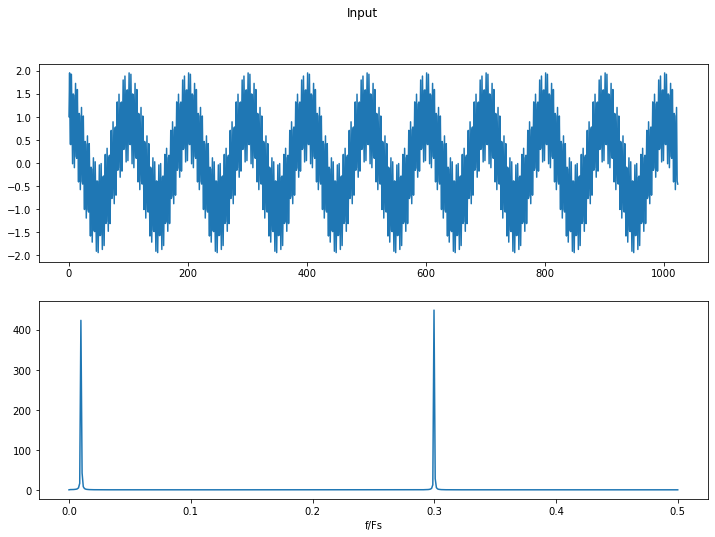

In [208]:
plt.subplot(2, 1, 1)
plt.plot(x)
plt.suptitle('Input')

f, Xf = sig.periodogram(x, Fs, nfft=1024)

plt.subplot(2, 1, 2)
plt.plot(f, Xf)
plt.xlabel('f/Fs')

Let's design a FIR filter to remove signal at 0.2 Hz.

Ntaps = 41


Text(0.5, 0.98, 'Filter')

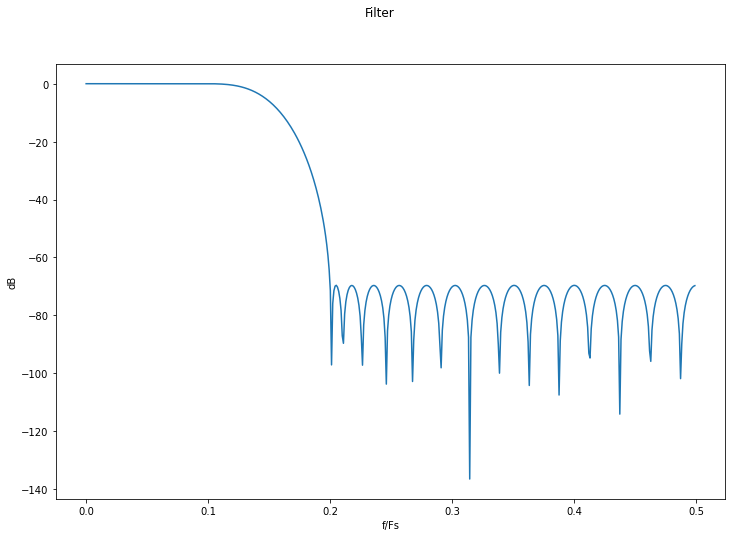

In [209]:
attn = 90.0
df = 0.1
Ntaps = int(np.ceil(Fs/df * attn/22.0))
print('Ntaps = {}'.format(Ntaps))

F = [0, 0.1, 0.2, 0.5]
A = [1, 0]
h = sig.remez(Ntaps, F, A, fs=Fs)

f, Hf = sig.freqz(h, 1, fs=Fs)

plt.plot(f, 20*np.log10(abs(Hf)))
plt.ylabel('dB')
plt.xlabel('f/Fs')
plt.suptitle('Filter')

## Filtering in Time Domain

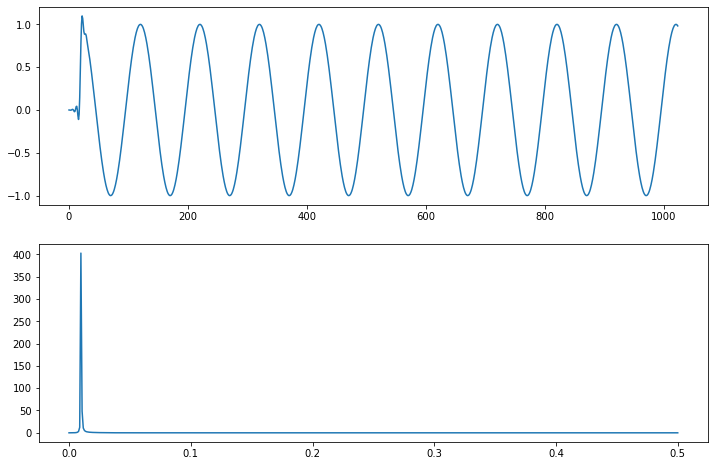

In [210]:
y0 = sig.lfilter(h, 1, x)
f0, Y0_f = sig.periodogram(y0, fs=Fs)

plt.subplot(2, 1, 1)
plt.plot(y0)
plt.subplot(2, 1, 2)
plt.plot(f0, abs(Y0_f))

## Filtering in Frequency Domain
The first step to filtering a series of samples in the frequency dominan is to take the DFT of the filter coefficients and the DFT of a frame of samples.  Let's assume a data frame size of 128 samples.  Assume the FFT size is the block size as well.

Text(0.5, 0.98, 'Filter Output, $N_{FFT}$=128')

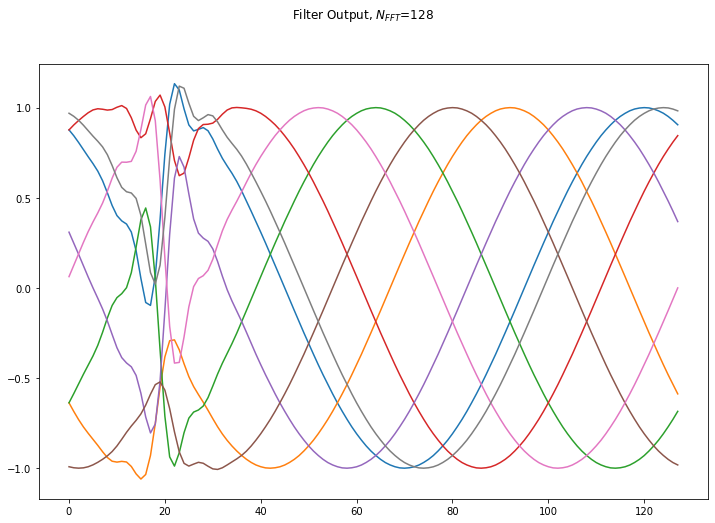

In [211]:
Nframe = 128
Nframes = int(len(x)/Nframe)
Nfft = Nframe

H_f = fft.fft(h, Nfft)
x_frame = np.reshape(x, (-1, Nframe))
Xframe_f = fft.fft(x_frame, Nfft, axis=1)

Yframe_f = Xframe_f * H_f
y_frame = np.real(fft.ifft(Yframe_f, Nfft))

plt.plot(y_frame.T)
plt.suptitle(r'Filter Output, $N_{FFT}$=%d' % Nfft)

In order to get filter transients at start and end of each block, we need to make FFT size large engouh to include transient and turn circular convolution into linear convolution.  Therefore, make FFT size block size plus filter length.

Text(0.5, 0.98, 'Filter Output, $N_{FFT}$=168')

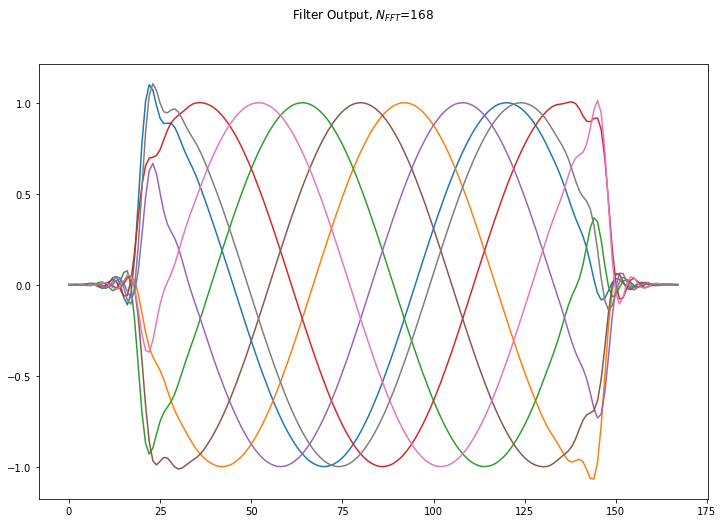

In [212]:
Nfft = Nframe + len(h) - 1

H_f = fft.fft(h, Nfft)
Xframe_f = fft.fft(x_frame, Nfft, axis=1)

Yframe_f = Xframe_f * H_f
y_frame = np.real(fft.ifft(Yframe_f, Nfft))

plt.plot(y_frame.T)
plt.suptitle(r'Filter Output, $N_{FFT}$=%d' % Nfft)

Now the we are have access to starting and ending filter transients for each block of samples, we should be able to perform and an `overlap and add` on the FFT outputs to reconstruct entire filtered output sequence.  The amount of overlap requied to constructively add filtered blocks is `Nfft - Nframe`.  For our case that is an overlap of 40 samples.

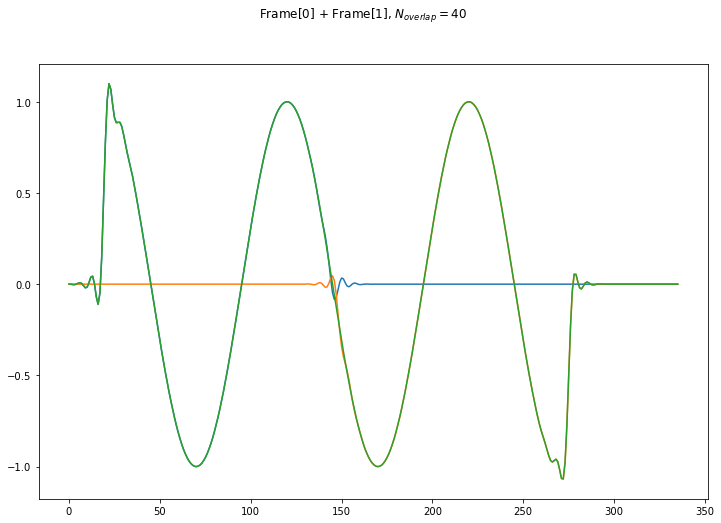

In [215]:
z = np.zeros((Nframes, Nframes*Nfft))
z[:,0:Nfft] = y_frame

Noverlap = Nfft - Nframe
for n in range(Nframes):
    z[n] = np.roll(z[n], n*Nframe)

plt.figure()
plt.plot(z[0][:2*Nfft])
plt.plot(z[1][:2*Nfft])
plt.plot(z[0][:2*Nfft] + z[1][:2*Nfft])
plt.suptitle(r'Frame[0] + Frame[1], $N_{overlap}=%d$' % Noverlap)

Therefore, by adding each block of filtered samples with specified overlap, we have performed filtering in frequency domain.

Text(0.5, 0.98, 'Frequency Domain Filter')

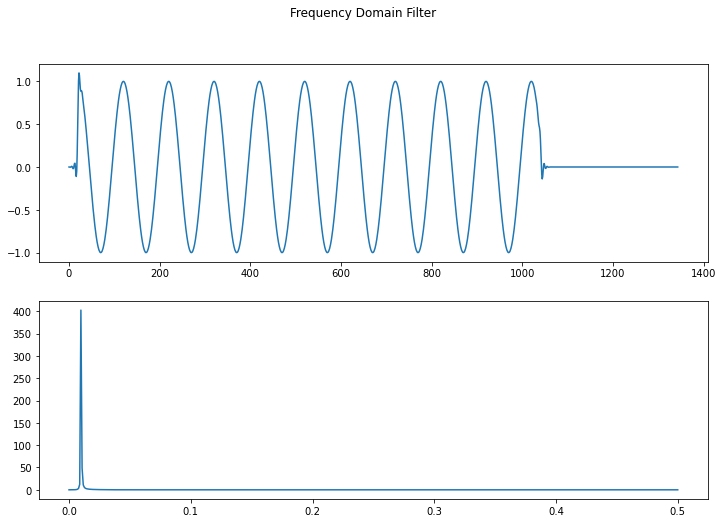

In [217]:
# Add each filter output with overlap.
y1 = np.sum(z, axis=0)
f1, Y1_f = sig.periodogram(y1, fs=Fs, nfft=1024)

plt.subplot(2, 1, 1)
plt.plot(y1)
plt.subplot(2, 1, 2)
plt.plot(f1, Y1_f)
plt.suptitle('Frequency Domain Filter')

Compaing time domain output to frequency domain output

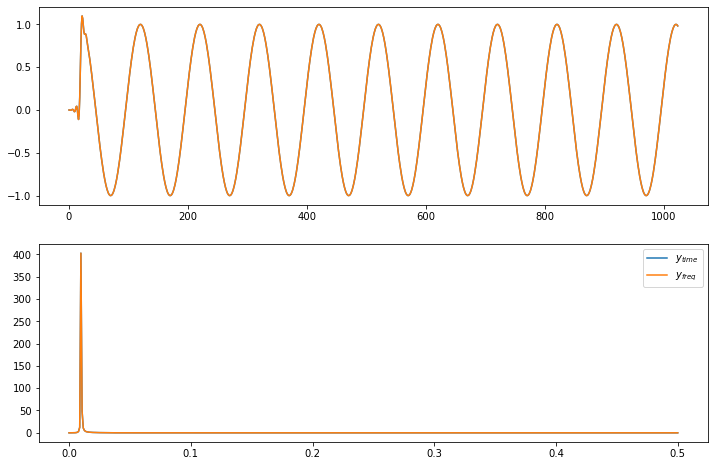

In [219]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(y0)
plt.plot(y1[:len(x)])
plt.subplot(2, 1, 2)
plt.plot(f0, Y0_f)
plt.plot(f1, Y1_f)
plt.legend([r'$y_{time}$', r'$y_{freq}$'])